In [1]:
import numpy as np
import copy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

from sumo_interface import start_sim

In [2]:
def random_dur(default_dur, sigma=1):
	default_dur = sum(default_dur,[])
	result =  np.clip(np.random.normal(default_dur,sigma*np.ones(len(default_dur)),len(default_dur)),0.5,60)
	#print("generated: ",result)
	return result

In [33]:
def evaluation(file_path,id_TLs,dur_TLs_):
	dur_TLs = copy.deepcopy(dur_TLs_)
	#print("eval ind: ",dur_TLs)
	edit_net(file_path,id_TLs,dur_TLs)
	#--> to sumo api

	start_sim(file_path+"/osm.sumocfg")
	import xml.etree.ElementTree as ET
	from numpy import mean
	#tree = ET.ElementTree(file = "/home/lynn/workspace/Untitled Folder/GA_Traffic_Optimization/result.xml")
	tree = ET.ElementTree(file = "/home/zhenyuli/workspace/GA_Traffic_Optimization/result.xml")
	trip_infos = tree.getroot()
	timeLoss = mean([float(trip.attrib['timeLoss']) for trip in trip_infos.findall("tripinfo")])

	print("##############################################################")
	print("##############################################################")
	print("avg time loss: ", timeLoss)
	print("##############################################################")
	print("##############################################################")
	return timeLoss,

In [4]:
def checkBounds(min, max):
    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator

In [22]:
def ga(file_path,default_dur,id_TLs):
	#parameters
	INIT_SIZE = 10
	MAX_ITER = 3
	SIGMA = 1
	P_CROSSOVER = 0.5
	P_MUTATION = 0.1
	MIN = 0.5
	MAX = 60

	#DEAP
	creator.create("FitnessMin",base.Fitness,weights=(-1.0,)) 
	creator.create("Individual",list,fitness=creator.FitnessMin) #individuals are returned in list

	toolbox = base.Toolbox()
	toolbox.register("attr_item", random_dur, default_dur, SIGMA)
	toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_item)
	toolbox.register("population", tools.initRepeat, list, toolbox.individual)

	toolbox.register("evaluate", evaluation, file_path,id_TLs)
	toolbox.register("edit_net", edit_net,file_path,id_TLs,dur_TLs)
	toolbox.register("start_sim",start_sim,file_path)
	toolbox.register("mate", tools.cxOnePoint)
	#toolbox.register("mate", crossover)23.789012557077626
	toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=SIGMA, indpb=0.1)
	toolbox.decorate("mutate", checkBounds(MIN, MAX))# Bounds are still needed to be set.

	toolbox.register("select", tools.selTournament, tournsize=5)
	#toolbox.decorate("select", printsel())

	pop = toolbox.population(n=INIT_SIZE)

	hof = tools.HallOfFame(1) #pick the best one
	stats = tools.Statistics(lambda ind: ind.fitness.values)
	stats.register("avg", np.mean)
	stats.register("std", np.std)
	stats.register("min", np.min)
	stats.register("max", np.max)

	pop,log = algorithms.eaSimple(pop,toolbox,cxpb=P_CROSSOVER,mutpb=P_MUTATION,ngen=MAX_ITER,stats=stats,halloffame=hof,verbose=True)

	return hof,log

In [23]:
def get_default_duration(file_path):
	import xml.etree.ElementTree as ET

	tree = ET.ElementTree(file = file_path+"/osm.net.xml")
	net = tree.getroot()
	trafficLights = net.findall("tlLogic")

	id_TLs = []
	dur_TLs = []
	for tl in trafficLights:
		id_TLs.append(tl.attrib['id'])
		durations = [phase.attrib['duration'] for phase in tl]
		dur_TLs.append(durations)

	return id_TLs,dur_TLs

In [26]:
def edit_net(file_path,id_TLs,dur_TLs):
	import xml.etree.ElementTree as ET

	tree = ET.ElementTree(file = file_path+"/osm.net.xml")
	net = tree.getroot()
	trafficLights = net.findall("tlLogic")

	tl_idx = [[tl.attrib['id'] for tl in trafficLights].index(id) for id in id_TLs]

	for i in tl_idx:
		nb_phase = len(trafficLights[i])
		for j in range(nb_phase):
			trafficLights[i][j].attrib["duration"] = str(dur_TLs.pop(0))
		#for j in range(len(dur_TLs[i])):
		#	trafficLights[i][j].attrib["duration"] = dur_TLs[i][j]

	tree.write(file_path+"/osm.net.xml")

In [34]:
MAP_PATH = "/home/zhenyuli/workspace/GA_Traffic_Optimization/wuhan"
#MAP_PATH = "/home/zhenyuli/Sumo/2020-02-08-00-46-38"
id_TLs, dur_TLs = get_default_duration(MAP_PATH)

best_solution,log = ga(MAP_PATH,dur_TLs,id_TLs)
print("best solution is: ",best_solution[0])
print("best time loss", best_solution[0].fitness.values)

/home/zhenyuli/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/zhenyuli/.local/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


generated:  [33.26029128  3.55364026  3.50559278 32.88961919  5.40756512  0.5
  5.70031915  3.96862441 34.10119975  2.76237288  2.99226788 35.16572649
  6.41469078  0.73863406 32.09270748  9.43195911  3.93818999 40.30668388
  6.73018066  2.50143255 38.09028379  5.49288982  0.5        37.02310684
  4.66925608  4.65091507 59.47708942  6.19716295  3.15961989  4.79988543
  5.35471137 37.45944486  0.5         0.67444204 35.29421629  6.07244063
  4.86578266 37.49431172  4.89095431 31.72058168  7.49609763  4.3394855
  7.77054889  4.77094544 39.94526198  6.05853409  0.5        32.30944714
  0.5         2.13251653 25.58817338  6.88236672  3.33907581  4.77507443
  5.8048769  25.44673189  4.57539318  2.69799999  5.70564782  3.64372074
 25.65904112  8.18019838  1.85156743  4.38691035  3.64278719 24.63398919
  7.73784292  0.51069304  4.15674631  1.25988898  5.04769684  0.5
 30.71264707  6.14947609  1.08536151  6.79572381  1.62149515 30.12922019
  3.76364214  0.5        35.29918942  6.72719189  3.78

##############################################################
##############################################################
avg time loss:  120.26187980632298
##############################################################
##############################################################
 Retrying in 1 seconds
##############################################################
##############################################################
avg time loss:  156.4555311876958
##############################################################
##############################################################
 Retrying in 1 seconds
##############################################################
##############################################################
avg time loss:  168.78625462831104
##############################################################
##############################################################
 Retrying in 1 seconds
##############################################################
########

##############################################################
##############################################################
avg time loss:  120.26187980632298
##############################################################
##############################################################
 Retrying in 1 seconds
##############################################################
##############################################################
avg time loss:  239.33128453432067
##############################################################
##############################################################
3  	5     	133.973	35.529 	120.262	239.331
best solution is:  [33.26029127669575, 3.5536402551097117, 3.5055927796534156, 32.889619193742824, 5.407565121736608, 0.5, 5.700319149445793, 3.9686244059770073, 34.10119974668387, 2.7623728812855766, 2.992267877415315, 35.16572649223848, 6.414690784173686, 0.7386340622195102, 32.09270748390013, 9.431959110571777, 3.9381899892323666, 40.30668387847008, 6.730

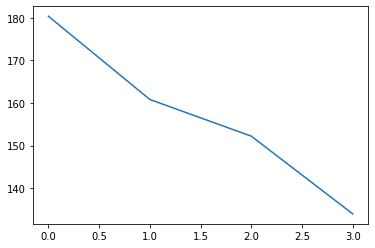

In [37]:
gen = log.select("gen")
fit_mins = log.select("avg")
import matplotlib.pyplot as plt
plt.plot(gen, fit_mins)

In [36]:
print(log)

gen	nevals	avg    	std    	min    	max    
0  	10    	180.333	47.4962	120.262	296.857
1  	8     	160.806	34.1472	120.262	231.276
2  	5     	152.204	27.4289	120.262	187.498
3  	5     	133.973	35.529 	120.262	239.331
